In [51]:
import numpy as np
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
import pygad
import wandb
import keras.backend as K
from tensorflow.python.client import device_lib
print(device_lib.list_local_devices())

tf.random.set_seed(0)
np.random.seed(0)

import scipy.io as sio

[name: "/device:CPU:0"
device_type: "CPU"
memory_limit: 268435456
locality {
}
incarnation: 16779768761411903075
xla_global_id: -1
]


2023-08-23 14:58:00.886802: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:981] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2023-08-23 14:58:00.887534: W tensorflow/core/common_runtime/gpu/gpu_device.cc:1934] Cannot dlopen some GPU libraries. Please make sure the missing libraries mentioned above are installed properly if you would like to use GPU. Follow the guide at https://www.tensorflow.org/install/gpu for how to download and setup the required libraries for your platform.
Skipping registering GPU devices...


Number of 6s in the new dataset: 39
Number of 0s in the new dataset: 5923


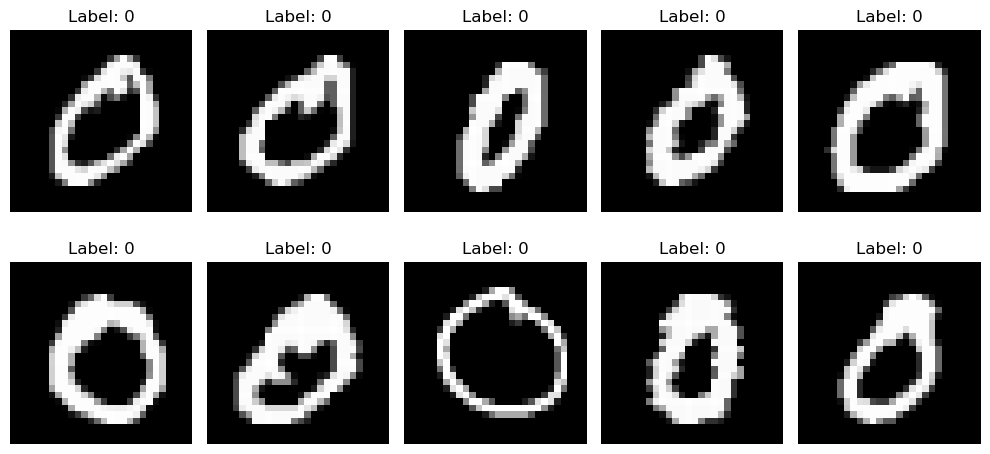

In [2]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt

# Load the MNIST dataset
(x_train, y_train), (x_test, y_test) = tf.keras.datasets.mnist.load_data()

# Filter 6s from the dataset
indices_6 = np.where(y_train == 0)[0]
filtered_images = x_train[indices_6]
filtered_labels = y_train[indices_6]

# Select a few 0s
indices_0 = np.where(y_train == 6)[0][:len(indices_6) // 150]  # Select 1/5th of the number of 6s
selected_images = x_train[indices_0]
selected_labels = y_train[indices_0]

# Combine the selected images (6s) with the few 0s
combined_images = np.concatenate((filtered_images, selected_images))
combined_labels = np.concatenate((filtered_labels, selected_labels))

# Count the occurrences of each label (6 or 0) in the combined dataset
num_6s = np.sum(combined_labels == 6)
num_0s = np.sum(combined_labels == 0)

# Display the counts
print(f"Number of 6s in the new dataset: {num_6s}")
print(f"Number of 0s in the new dataset: {num_0s}")

# Visualize some samples from the custom dataset
plt.figure(figsize=(10, 5))
for i in range(10):
    plt.subplot(2, 5, i+1)
    plt.imshow(combined_images[i], cmap='gray')
    plt.title(f'Label: {combined_labels[i]}')
    plt.axis('off')

plt.tight_layout()
plt.show()

# Save the custom dataset
# np.savez_compressed('custom_mnist.npz', images=combined_images, labels=combined_labels)


Shape of reshaped images: (5962, 784)


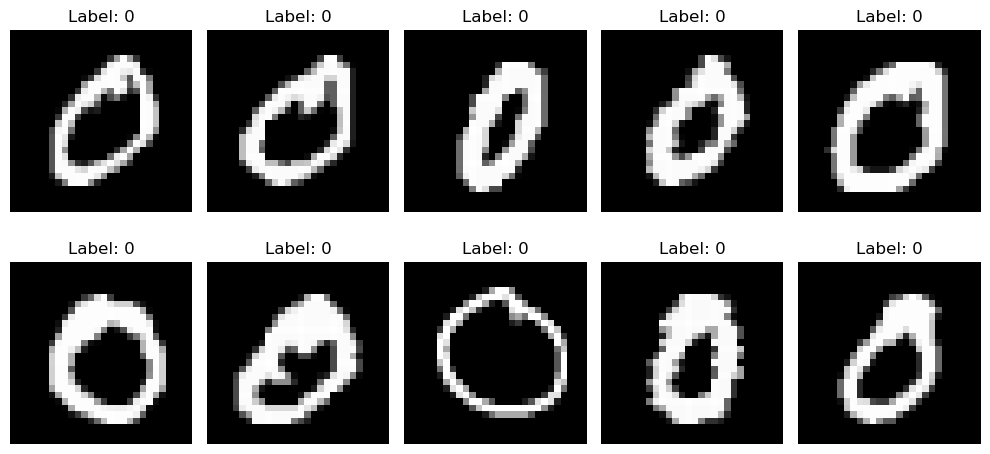

Original dataset shape: (5962, 28, 28)
Downsampled dataset shape: (5962, 15, 15)


In [3]:
import matplotlib.pyplot as plt
from scipy.ndimage import zoom
# Load the custom dataset
custom_dataset = np.load('custom_mnist.npz')
combined_images = custom_dataset['images']
combined_labels = custom_dataset['labels']

# Reshape the images as 1D arrays
num_images = len(combined_images)
image_size = combined_images.shape[1] * combined_images.shape[2]
reshaped_images = combined_images.reshape(num_images, image_size)

# Display the shape of the reshaped images
print("Shape of reshaped images:", reshaped_images.shape)

# Visualize some reshaped images
plt.figure(figsize=(10, 5))
for i in range(10):
    plt.subplot(2, 5, i+1)
    plt.imshow(reshaped_images[i].reshape(28, 28), cmap='gray')
    plt.title(f'Label: {combined_labels[i]}')
    plt.axis('off')

plt.tight_layout()
plt.show()

output_size = (15, 15)

downsampled_images = np.zeros((combined_images.shape[0], *output_size))

# Downsample each image in the dataset
for i, image in enumerate(combined_images):
    downsampled_images[i] = zoom(image, (output_size[0] / image.shape[0], output_size[1] / image.shape[1]))

image_size = downsampled_images.shape[1] * downsampled_images.shape[2]
reshaped_images = downsampled_images.reshape(num_images, image_size)

# Verify the shape of the downsampled images
print("Original dataset shape:", combined_images.shape)
print("Downsampled dataset shape:", downsampled_images.shape)

normalized_images = reshaped_images / 255.0


In [42]:
import numpy as np
import tensorflow as tf
from tensorflow.keras.datasets import mnist
from tensorflow.keras.layers import Input, Dense, Layer
from tensorflow.keras.models import Model
from tensorflow.keras.losses import MeanSquaredError
from tensorflow.keras import backend as K

# Load the MNIST dataset
(x_train, _), (x_test, _) = mnist.load_data()

# Normalize and flatten the input data
x_train = x_train.astype('float32') / 255.0
x_test = x_test.astype('float32') / 255.0
x_train = x_train.reshape((-1, 28*28))
x_test = x_test.reshape((-1, 28*28))

# Custom decoder layer
class CustomDecoderLayer(Layer):
    def __init__(self, **kwargs):
        super(CustomDecoderLayer, self).__init__(**kwargs)
        self.decoder = Dense(input_dim, activation='sigmoid')
    
    def call(self, inputs):
        return self.decoder(inputs)

# Build the autoencoder model
input_dim = 784  # 28x28 flattened MNIST images
encoding_dim = 64

input_layer = Input(shape=(input_dim,))
encoder = Dense(encoding_dim, activation='relu')(input_layer)
custom_decoder = CustomDecoderLayer()(encoder)

autoencoder = Model(inputs=input_layer, outputs=custom_decoder)

# Define the custom loss function
def custom_loss(y_true, y_pred):
    # Reconstruction loss
    reconstruction_loss = MeanSquaredError()(y_true, y_pred)
    
    # L2 norm of the latent space
    latent_norm = tf.norm(encoder, ord=2)
    
    # Compute gradients of the total loss with respect to decoder's trainable weights
    with tf.GradientTape() as tape:
        reconstruction_loss = MeanSquaredError()(y_true, y_pred)
    gradients = tape.gradient(reconstruction_loss, autoencoder.trainable_weights)
    
    # Calculate gradient norm, ignoring None gradients
    gradient_norm = 0.0
    for gradient in gradients:
        if gradient is not None:
            gradient_norm += tf.norm(gradient, ord=2)
    
    total_loss = reconstruction_loss + 0.001 * latent_norm + 0.001 * gradient_norm
    return total_loss

# Compile the model with the custom loss function
autoencoder.compile(optimizer='adam', loss=custom_loss)

# Train the autoencoder
autoencoder.fit(x_train, x_train, epochs=20, batch_size=256, shuffle=True, validation_data=(x_test, x_test))

# Use the trained autoencoder to reconstruct input data
reconstructed_data = autoencoder.predict(x_test)

# Optionally visualize some results
import matplotlib.pyplot as plt

n = 10
plt.figure(figsize=(20, 4))
for i in range(n):
    # Original images
    ax = plt.subplot(2, n, i + 1)
    plt.imshow(x_test[i].reshape(28, 28))
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
    
    # Reconstructed images
    ax = plt.subplot(2, n, i + 1 + n)
    plt.imshow(reconstructed_data[i].reshape(28, 28))
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
plt.show()


Epoch 1/20


TypeError: in user code:

    File "/home/macula/SMATousi/.conda/envs/mac-deep/lib/python3.7/site-packages/keras/engine/training.py", line 1249, in train_function  *
        return step_function(self, iterator)
    File "/home/macula/SMATousi/.conda/envs/mac-deep/lib/python3.7/site-packages/keras/engine/training.py", line 1233, in step_function  **
        outputs = model.distribute_strategy.run(run_step, args=(data,))
    File "/home/macula/SMATousi/.conda/envs/mac-deep/lib/python3.7/site-packages/keras/engine/training.py", line 1222, in run_step  **
        outputs = model.train_step(data)
    File "/home/macula/SMATousi/.conda/envs/mac-deep/lib/python3.7/site-packages/keras/engine/training.py", line 1024, in train_step
        loss = self.compute_loss(x, y, y_pred, sample_weight)
    File "/home/macula/SMATousi/.conda/envs/mac-deep/lib/python3.7/site-packages/keras/engine/training.py", line 1083, in compute_loss
        y, y_pred, sample_weight, regularization_losses=self.losses
    File "/home/macula/SMATousi/.conda/envs/mac-deep/lib/python3.7/site-packages/keras/engine/compile_utils.py", line 318, in __call__
        total_total_loss_mean_value, sample_weight=batch_dim
    File "/home/macula/SMATousi/.conda/envs/mac-deep/lib/python3.7/site-packages/keras/utils/metrics_utils.py", line 77, in decorated
        update_op = update_state_fn(*args, **kwargs)
    File "/home/macula/SMATousi/.conda/envs/mac-deep/lib/python3.7/site-packages/keras/metrics/base_metric.py", line 140, in update_state_fn
        return ag_update_state(*args, **kwargs)
    File "/home/macula/SMATousi/.conda/envs/mac-deep/lib/python3.7/site-packages/keras/metrics/base_metric.py", line 478, in update_state  **
        sample_weight, values
    File "/home/macula/SMATousi/.conda/envs/mac-deep/lib/python3.7/site-packages/keras/engine/keras_tensor.py", line 284, in __array__
        f"You are passing {self}, an intermediate Keras symbolic "

    TypeError: You are passing KerasTensor(type_spec=TensorSpec(shape=(), dtype=tf.float32, name=None), name='Placeholder:0', description="created by layer 'tf.cast_20'"), an intermediate Keras symbolic input/output, to a TF API that does not allow registering custom dispatchers, such as `tf.cond`, `tf.function`, gradient tapes, or `tf.map_fn`. Keras Functional model construction only supports TF API calls that *do* support dispatching, such as `tf.math.add` or `tf.reshape`. Other APIs cannot be called directly on symbolic Kerasinputs/outputs. You can work around this limitation by putting the operation in a custom Keras layer `call` and calling that layer on this symbolic input/output.


In [11]:
import numpy as np
import tensorflow as tf
from tensorflow.keras.layers import Input, Dense
from tensorflow.keras.models import Model
from tensorflow.keras.losses import MeanSquaredError

# Custom loss function with L2 encoded regularization and gradient regularization
def custom_loss(y_true, y_pred):
    reconstruction_loss = tf.reduce_mean(tf.square(y_true - y_pred))
    
    # L2 regularization term for encoded representations
    encoded_norm = tf.norm(encoder_layer, ord=2)
    
    # Gradient regularization term
    gradients = tf.gradients(y_pred, input_layer)[0]
    gradient_norm = tf.reduce_sum(tf.square(gradients))
    
    total_loss = reconstruction_loss + encoded_norm + gradient_norm
    return total_loss

# Create a simple autoencoder model
input_dim = 784  # For example, MNIST images flattened to 784 dimensions
encoding_dim = 128

input_layer = Input(shape=(input_dim,))
encoder_layer = Dense(encoding_dim, activation='relu')(input_layer)
decoder_layer = Dense(input_dim, activation='sigmoid')(encoder_layer)

autoencoder = Model(inputs=input_layer, outputs=decoder_layer)

# Compile the model with the custom loss function
autoencoder.compile(optimizer='adam', loss=custom_loss)

# Generate some example data
num_samples = 1000
x_train = np.random.rand(num_samples, input_dim)

# Train the autoencoder
autoencoder.fit(x_train, x_train, epochs=50, batch_size=32)

# Use the trained autoencoder to reconstruct input data
reconstructed_data = autoencoder.predict(x_train)


Epoch 1/50


TypeError: in user code:

    File "/home/macula/SMATousi/.conda/envs/mac-deep/lib/python3.7/site-packages/keras/engine/training.py", line 1249, in train_function  *
        return step_function(self, iterator)
    File "/tmp/ipykernel_2713066/1456308587.py", line 15, in custom_loss  *
        gradients = tf.gradients(y_pred, input_layer)[0]
    File "/home/macula/SMATousi/.conda/envs/mac-deep/lib/python3.7/site-packages/keras/engine/keras_tensor.py", line 284, in __array__
        f"You are passing {self}, an intermediate Keras symbolic "

    TypeError: You are passing KerasTensor(type_spec=TensorSpec(shape=(None, 784), dtype=tf.float32, name='input_8'), name='input_8', description="created by layer 'input_8'"), an intermediate Keras symbolic input/output, to a TF API that does not allow registering custom dispatchers, such as `tf.cond`, `tf.function`, gradient tapes, or `tf.map_fn`. Keras Functional model construction only supports TF API calls that *do* support dispatching, such as `tf.math.add` or `tf.reshape`. Other APIs cannot be called directly on symbolic Kerasinputs/outputs. You can work around this limitation by putting the operation in a custom Keras layer `call` and calling that layer on this symbolic input/output.


In [58]:
latent_dim = 5

encoder_inputs = keras.Input(shape=(225,))
# x = layers.Conv2D(32, 3, activation="relu", strides=2, padding="same")(encoder_inputs)
# x = layers.Conv2D(64, 3, activation="relu", strides=2, padding="same")(x)
# x = layers.Flatten()(x)
x = layers.Dense(512, activation="relu")(encoder_inputs)
x = layers.Dense(256, activation="relu")(x)
x = layers.Dense(128, activation="relu")(x)
encoder_output = layers.Dense(latent_dim, activation="relu")(x)
# z_mean = layers.Dense(latent_dim, name="z_mean")(x)
# z_log_var = layers.Dense(latent_dim, name="z_log_var")(x)
# z = Sampling()([z_mean, z_log_var])
encoder = keras.Model(encoder_inputs, encoder_output, name="encoder")

latent_inputs = keras.Input(shape=(latent_dim,))
# x = layers.Dense(7 * 7 * 64, activation="relu")(latent_inputs)
# x = layers.Reshape((7, 7, 64))(x)
# x = layers.Conv2DTranspose(64, 3, activation="relu", strides=2, padding="same")(x)
# x = layers.Conv2DTranspose(32, 3, activation="relu", strides=2, padding="same")(x)
# decoder_outputs = layers.Conv2DTranspose(1, 3, activation="sigmoid", padding="same")(x)
x = layers.Dense(64, activation="relu")(latent_inputs)
x = layers.Dense(128, activation="relu")(x)
x = layers.Dense(256, activation="relu")(x)
x = layers.Dense(512, activation="relu")(x)
decoder_outputs = layers.Dense(225, activation="tanh")(x)
decoder = keras.Model(latent_inputs, decoder_outputs, name="decoder")



class RAE(keras.Model):
    def __init__(self, encoder, decoder, **kwargs):
        super().__init__(**kwargs)
        self.encoder = encoder
        self.decoder = decoder
        self.total_loss_tracker = keras.metrics.Mean(name="total_loss")
        self.reconstruction_loss_tracker = keras.metrics.Mean(
            name="reconstruction_loss"
        )
        self.z_tracker = keras.metrics.Mean(name="z_loss")
        self.REG_tracker = keras.metrics.Mean(name="REG_loss")

    @property
    def metrics(self):
        return [
            self.total_loss_tracker,
            self.reconstruction_loss_tracker,
            self.z_tracker,
            self.REG_tracker,
        ]

    def train_step(self, data):
        with tf.GradientTape(persistent=True) as tape:
            z = self.encoder(data)
            reconstruction = self.decoder(z)
#             reconstruction_loss = tf.reduce_mean(
#                 tf.reduce_sum(
#                     keras.losses.binary_crossentropy(data, reconstruction), axis=(1, 2)
#                 )
#             )
            reconstruction_loss = tf.keras.losses.MeanSquaredError()(data,reconstruction)
#             reconstruction_loss = tf.keras.losses.BinaryCrossentropy()(data, reconstruction)
#             
            z_loss = K.mean(K.square(z), axis=[1])
    

#             gradients = tape.gradient(reconstruction, self.encoder(data))
    

#             gradient_norm = 0.0
#             for gradient in gradients:
#                 if gradient is not None:
#                     gradient_norm += tf.norm(gradient, ord=2)
    

            REG_loss = K.mean(K.square(K.gradients(K.square(reconstruction), z)))

            total_loss = reconstruction_loss +  0.01 * z_loss + 0.01 * REG_loss
        
        grads = tape.gradient(total_loss, self.trainable_weights)
        self.optimizer.apply_gradients(zip(grads, self.trainable_weights))
        self.total_loss_tracker.update_state(total_loss)
        self.reconstruction_loss_tracker.update_state(reconstruction_loss)
        self.z_tracker.update_state(z_loss)
        self.REG_tracker.update_state(REG_loss)
        del tape
        return {
            "loss": self.total_loss_tracker.result(),
            "reconstruction_loss": self.reconstruction_loss_tracker.result(),
            "z_loss": self.z_tracker.result(),
            "REG_loss": self.REG_tracker.result(),
        }
        

# mnist_data = mat_data['X']
tdata = np.concatenate([normalized_images], axis=0)
tdata = np.expand_dims(tdata, -1).astype("float32")

rae = RAE(encoder, decoder)
rae.compile(optimizer=tf.keras.optimizers.legacy.Adam())
history = rae.fit(tdata, epochs=100, batch_size=1024)

Epoch 1/100
6/6 [==============================] - 0s 22ms/step - loss: 0.1267 - reconstruction_loss: 0.1090 - z_loss: 0.5241 - REG_loss: 0.5773
Epoch 2/100
6/6 [==============================] - 0s 29ms/step - loss: 0.1046 - reconstruction_loss: 0.0861 - z_loss: 0.6020 - REG_loss: 1.1179
Epoch 3/100
6/6 [==============================] - 0s 33ms/step - loss: 0.0988 - reconstruction_loss: 0.0796 - z_loss: 0.9416 - REG_loss: 0.8897
Epoch 4/100
6/6 [==============================] - 0s 36ms/step - loss: 0.0930 - reconstruction_loss: 0.0746 - z_loss: 0.6804 - REG_loss: 1.0112
Epoch 5/100
6/6 [==============================] - 0s 31ms/step - loss: 0.0846 - reconstruction_loss: 0.0684 - z_loss: 0.6646 - REG_loss: 0.7826
Epoch 6/100
6/6 [==============================] - 0s 38ms/step - loss: 0.0725 - reconstruction_loss: 0.0602 - z_loss: 0.4207 - REG_loss: 0.5600
Epoch 7/100
6/6 [==============================] - 0s 27ms/step - loss: 0.0593 - reconstruction_loss: 0.0483 - z_loss: 0.2851 - RE

6/6 [==============================] - 0s 31ms/step - loss: 0.0318 - reconstruction_loss: 0.0298 - z_loss: 0.1004 - REG_loss: 0.0954
Epoch 58/100
6/6 [==============================] - 0s 29ms/step - loss: 0.0316 - reconstruction_loss: 0.0297 - z_loss: 0.1018 - REG_loss: 0.1020
Epoch 59/100
6/6 [==============================] - 0s 32ms/step - loss: 0.0318 - reconstruction_loss: 0.0297 - z_loss: 0.1017 - REG_loss: 0.1088
Epoch 60/100
6/6 [==============================] - 0s 35ms/step - loss: 0.0317 - reconstruction_loss: 0.0296 - z_loss: 0.1018 - REG_loss: 0.1013
Epoch 61/100
6/6 [==============================] - 0s 33ms/step - loss: 0.0315 - reconstruction_loss: 0.0296 - z_loss: 0.1001 - REG_loss: 0.0829
Epoch 62/100
6/6 [==============================] - 0s 27ms/step - loss: 0.0310 - reconstruction_loss: 0.0295 - z_loss: 0.0995 - REG_loss: 0.0706
Epoch 63/100
6/6 [==============================] - 0s 35ms/step - loss: 0.0311 - reconstruction_loss: 0.0294 - z_loss: 0.0976 - REG_loss

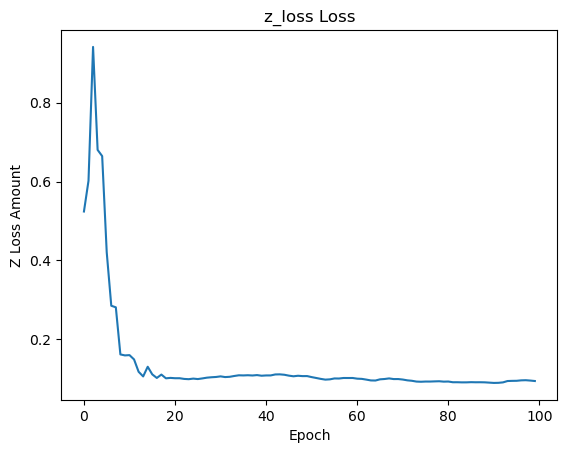

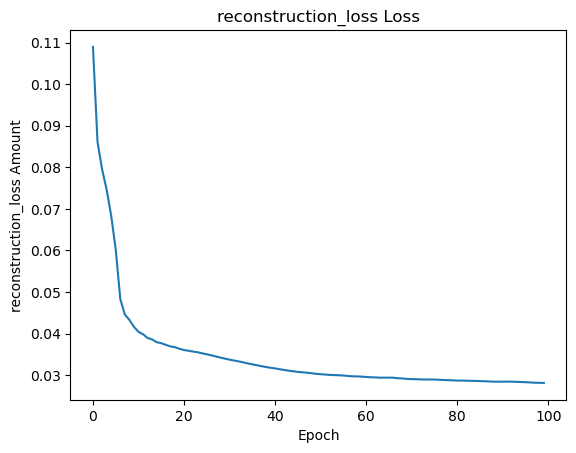

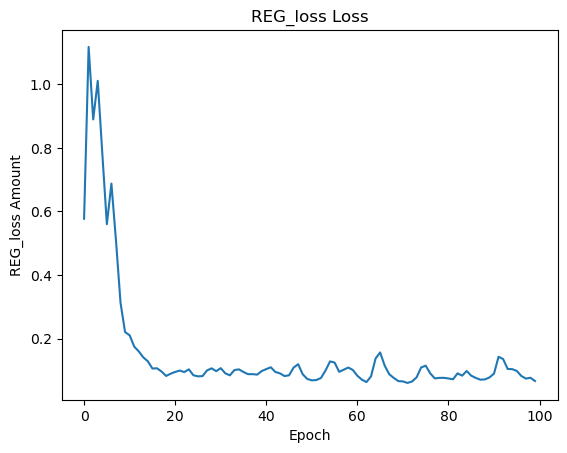

In [59]:
plt.plot(history.history['z_loss'])
plt.title('z_loss Loss')
plt.xlabel('Epoch')
plt.ylabel('Z Loss Amount')
plt.show()

plt.plot(history.history['reconstruction_loss'])
plt.title('reconstruction_loss Loss')
plt.xlabel('Epoch')
plt.ylabel('reconstruction_loss Amount')
plt.show()

plt.plot(history.history['REG_loss'])
plt.title('REG_loss Loss')
plt.xlabel('Epoch')
plt.ylabel('REG_loss Amount')
plt.show()

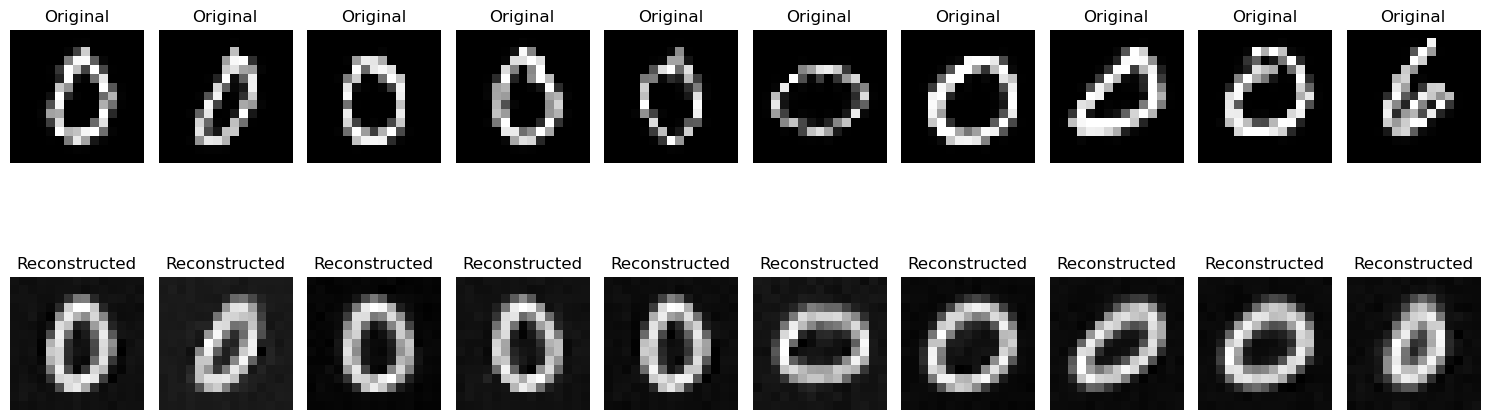

In [60]:
num_reconstructed_images = 10
indices_6 = np.where(combined_labels == 6)[0]

random_indices = np.random.choice(len(downsampled_images), num_reconstructed_images - 1, replace=False)
selected_indices = np.append(random_indices, indices_6[0])
selected_images = normalized_images[selected_indices]

# Reconstruct the selected images using the VAE
reconstructed_images = []

for i in range(num_reconstructed_images):
    
    sample = selected_images[i].reshape([1,225])
    
    z = rae.encoder(sample)
    reconstruction = rae.decoder(z)
    
    reconstructed_images.append(reconstruction)

reconstructed_images = np.array(reconstructed_images)
# Display the original and reconstructed images side by side
plt.figure(figsize=(15, 6))
for i in range(num_reconstructed_images):
    plt.subplot(2, num_reconstructed_images, i + 1)
    plt.imshow(selected_images[i].reshape(15, 15), cmap='gray')
    plt.title('Original')
    plt.axis('off')

    plt.subplot(2, num_reconstructed_images, i + num_reconstructed_images + 1)
    plt.imshow(reconstructed_images[i].reshape(15, 15), cmap='gray')
    plt.title('Reconstructed')
    plt.axis('off')

plt.tight_layout()
plt.show()


In [62]:
out_rec = []

for i in range(combined_labels.shape[0]):
    
    if combined_labels[i] == 0:
        
        sample = normalized_images[i,:].reshape([1,225])

        z = rae.encoder(sample)
        reconstruction = rae.decoder(z)
        reconstruction_loss = tf.keras.losses.MeanSquaredError()(sample,reconstruction)
#         kl_loss = -0.5 * (1 + z_log_var - tf.square(z_mean) - tf.exp(z_log_var))
# #             kl_loss = tf.reduce_mean(tf.reduce_sum(kl_loss, axis=1))
#         total_loss = reconstruction_loss +  0.08 * kl_loss

        
        out_rec.append(reconstruction_loss.numpy())

print("Mean = ", np.mean(np.array(out_rec)))
print("Std = ", np.std(np.array(out_rec)))

Mean =  0.027966585
Std =  0.010718948
